In [200]:
import os
import sys
import json5
import numpy as np
import scipy
from itertools import tee, chain
from collections import defaultdict, Counter

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [201]:
block_root = '/ddr'
v_path = os.path.join(block_root, '/rtl/cadence_ddr_controller.v.preproc.v')
comp_json_path = os.path.join(block_root, 'ddr.json5')
with open(comp_json_path) as fin:
    block = json5.load(fin)
ports = []
for name, pw in block['definitions']['ports'].items():
    try:
        w, d = np.abs(pw), np.sign(pw)
    except Exception as e:
        print('Warning', (name, pw), 'not correctly parsed')
        w, d = None, np.sign(-1) if pw[0] == '-' else np.sign(1)
    ports.append( (name, w, d) )

Warning ('regHADDR', 'PAR_REG_ADDR_WIDTH + 2') not correctly parsed
Warning ('phy_reg_addr', '-(PAR_REG_ADDR_WIDTH)') not correctly parsed


In [316]:
def words_from_name(wire, pad=False):
    words = wire.split('_')
    if pad:
        return chain([None], words, [None])
    else:
        return words

class GroupVectorizer(object):
    @property
    def size(self): return self._size
    def __init__(self, words):
        self._idx_word_map = dict(enumerate(words))
        self._word_idx_map = dict(
            [(v, k) for (k, v) in enumerate(words)],
        )
        self._size = len(words)
        
    def get_vec(self, words):
        v = np.zeros(self.size, dtype=bool)
        for w in words:
            assert w in self._word_idx_map
            v[self._word_idx_map[w]] = True
        return v
    
    def get_attrs(self):
        return np.array(list(map(
            lambda x: x[1],
            sorted(self._idx_word_map.items()),
        )))
    
class Vectorizer(object):
    @property
    def size(self): return sum([gv.size for _, gv in self.group_vectorizers.items()])
    @property
    def max_words(self): return self._max_words
                               
    def __init__(self, wire_names):
        group_words = defaultdict(set)
        #words = set()
        
        # determine number of word groups based on wire_names
        idx = np.argmax(list(map(
            lambda x: len(list(words_from_name(x, pad=True))),
            wire_names,
        )))
        mwire = wire_names[idx]
        self._max_words = len(list(words_from_name(mwire, pad=True)))
        
        for wire_name in wire_names:
            for i, (w1, w2) in self.__iter_groups__(wire_name):
                for w in w1, w2:
                    group_words[i].add(w)
                    #if w != None:
                    #    words.add(w)
        self.group_vectorizers = dict([(i, GroupVectorizer(words)) for (i, words) in group_words.items()])
        
    def __words_from_name__(self, wire_name):
        base_words = list(words_from_name(wire_name, pad=True))
        slop = self._max_words - len(base_words)
        # can pad with the wire_name itself so wires with smaller 
        # number of words are not biased to cluster with each other
        #pad = None
        pad = wire_name
        return chain(base_words, [pad]*slop)
    
    def __iter_groups__(self, wire_name):
        return enumerate(pairwise(self.__words_from_name__(wire_name)))
        
    def get_vec(self, wire_name):
        vs = np.hstack(
            [self.group_vectorizers[i].get_vec(words)
                for i, words in self.__iter_groups__(wire_name)]
        )
        return np.hstack(vs)
    
    def get_attrs(self):
        return np.hstack([gv.get_attrs() for i, gv in sorted(self.group_vectorizers.items())])


In [308]:
wire_names = list(map(lambda w: w[0], ports))
wire_attrs = dict(map(lambda w: (w[0], (w[1:])), ports))
v = Vectorizer(wire_names)

[('scanen', (1, 1)), ('scanin', (1, 1)), ('scanout', (1, -1)), ('scanmode', (1, 1)), ('controller_int', (1, -1)), ('mem_rst_valid', (1, -1)), ('dfi_wrlvl_resp', (9, 1)), ('dfi_wrlvl_req', (9, 1)), ('dfi_phy_wrlvl_cs0_n', (2, 1)), ('dfi_phy_wrlvl_cs1_n', (2, 1))]


In [209]:
def get_wires():
    ws = list(wire_names)
    #return ws
    ws = ws[:40]
    ws = wire_names_s
    def swap(i, j):
        ws[i], ws[j] = ws[j], ws[i]
    swap(1,18)
    swap(5,11)
    return ws

[[ 36.          37.           2.           2.        ]
 [ 33.          34.           2.           2.        ]
 [ 35.          41.           2.           3.        ]
 [ 40.          42.           2.           5.        ]
 [ 29.          30.           2.           2.        ]
 [ 31.          44.           2.           3.        ]
 [ 32.          45.           2.           4.        ]
 [ 43.          46.           2.           9.        ]
 [  8.           9.           2.44948974   2.        ]
 [ 10.          48.           2.44948974   3.        ]
 [ 11.          49.           2.44948974   4.        ]
 [ 12.          50.           2.44948974   5.        ]
 [ 13.          51.           2.44948974   6.        ]
 [ 14.          52.           2.44948974   7.        ]
 [ 15.          53.           2.44948974   8.        ]
 [ 16.          54.           2.44948974   9.        ]
 [ 20.          21.           2.44948974   2.        ]
 [ 22.          56.           2.44948974   3.        ]
 [ 23.    

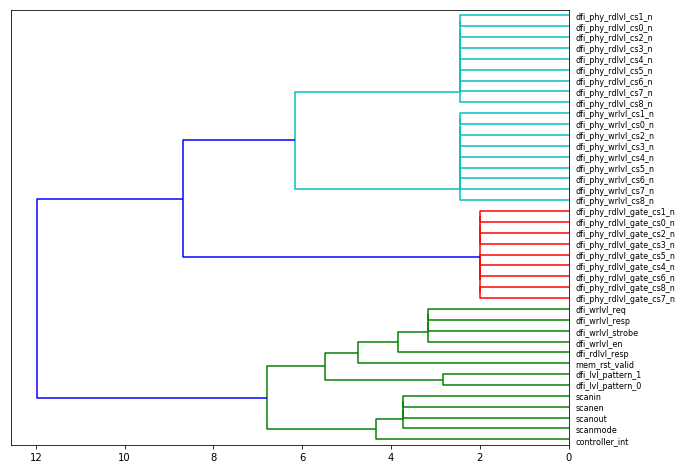

In [221]:
from matplotlib import pyplot as pyplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, to_tree

wire_names = get_wires()
vs = [v.get_vec(name) for name in wire_names]
X = np.vstack(vs)
Z = linkage(X, 'ward')
print(Z[:,:])

fig, ax = pyplot.subplots(1,1, figsize=(10,8))
dendrogram(
    Z,
    ax=ax,
    orientation='left',
    labels=wire_names_s,
)
pyplot.show()

In [288]:
# ClusterNode helpers
def pre_order_n(node, func=(lambda x: x.id)):
    """
    modified from ClusterNode src to invoke func at non-leaf nodes as well
    """
    # Do a preorder traversal, caching the result. To avoid having to do
    # recursion, we'll store the previous index we've visited in a vector.
    n = node.count
    
    curNode = [None] * (2 * n)
    lvisited = set()
    rvisited = set()
    curNode[0] = node
    k = 0
    preorder = []
    while k >= 0:
        nd = curNode[k]
        ndid = nd.id
        if nd.is_leaf():
            preorder.append(func(nd))
            k = k - 1
        else:
            if ndid not in lvisited:
                curNode[k + 1] = nd.left
                lvisited.add(ndid)
                k = k + 1
            elif ndid not in rvisited:
                curNode[k + 1] = nd.right
                rvisited.add(ndid)
                k = k + 1
            # If we've visited the left and right of this non-leaf
            # node already, go up in the tree.
            else:
                k = k - 1
                preorder.append(func(nd))
    
    return preorder

def add_parent(node, parent):
    node.parent = parent
    
def tag_parent(node):
    if not node.is_leaf():
        add_parent(node.get_left(), node)
        add_parent(node.get_right(), node)

In [305]:
class WireGrouper(object):
    """
    Build a tree off an input hierarchical clustering linkage matrix Z
    
    Yield all parent groupings of a given input wire
    """
    def __init__(self, wire_names, Z):
        self.root_node, self.node_list = to_tree(Z, rd=True)

        # default no parents
        for n in self.node_list:
            add_parent(n, None)
        # traverse tree and tag parents
        _ = pre_order_n(self.root_node, tag_parent)
    
        leaves = list(filter(lambda n: n.is_leaf(), node_list))
        self.wire_node_map = dict(zip(
            wire_names,
            sorted(leaves, key=lambda n: n.id),
        ))
        self.id_wire_map = dict(map(
            lambda x: (x[1].id, x[0]),
            wire_node_map.items(),
        ))
        self.leaf_ids = set(map(lambda n: n.id, leaves))
        
    def get_group_leaves(self, node):
        return list(filter(
            lambda n: n.id in self.leaf_ids,
            pre_order_n(node, lambda n: n),
        ))
    
    def get_wire_groups(self, wire):
        assert wire in self.wire_node_map
        curr = self.wire_node_map[wire]
        assert curr.parent is not None
        # traverse up until the root
        while curr is not None:
            group = self.get_group_leaves(curr)
            yield set(map(lambda n: id_wire_map[n.id], group))
            curr = curr.parent
        
name = wire_names[34]
wg = WireGrouper(wire_names, Z)
for i, group in enumerate(wg.get_wire_groups(name)):
    print('group {}, size: {}'.format(i, len(group)))
    for wire in group:
        print('  - ', wire)

group 0, size: 1
  -  dfi_phy_rdlvl_gate_cs5_n
group 1, size: 2
  -  dfi_phy_rdlvl_gate_cs4_n
  -  dfi_phy_rdlvl_gate_cs5_n
group 2, size: 3
  -  dfi_phy_rdlvl_gate_cs4_n
  -  dfi_phy_rdlvl_gate_cs5_n
  -  dfi_phy_rdlvl_gate_cs6_n
group 3, size: 5
  -  dfi_phy_rdlvl_gate_cs8_n
  -  dfi_phy_rdlvl_gate_cs4_n
  -  dfi_phy_rdlvl_gate_cs5_n
  -  dfi_phy_rdlvl_gate_cs7_n
  -  dfi_phy_rdlvl_gate_cs6_n
group 4, size: 9
  -  dfi_phy_rdlvl_gate_cs8_n
  -  dfi_phy_rdlvl_gate_cs1_n
  -  dfi_phy_rdlvl_gate_cs0_n
  -  dfi_phy_rdlvl_gate_cs3_n
  -  dfi_phy_rdlvl_gate_cs4_n
  -  dfi_phy_rdlvl_gate_cs5_n
  -  dfi_phy_rdlvl_gate_cs7_n
  -  dfi_phy_rdlvl_gate_cs6_n
  -  dfi_phy_rdlvl_gate_cs2_n
group 5, size: 27
  -  dfi_phy_rdlvl_gate_cs3_n
  -  dfi_phy_rdlvl_cs0_n
  -  dfi_phy_rdlvl_cs6_n
  -  dfi_phy_wrlvl_cs8_n
  -  dfi_phy_rdlvl_cs5_n
  -  dfi_phy_wrlvl_cs6_n
  -  dfi_phy_rdlvl_cs4_n
  -  dfi_phy_wrlvl_cs7_n
  -  dfi_phy_rdlvl_gate_cs5_n
  -  dfi_phy_rdlvl_gate_cs7_n
  -  dfi_phy_wrlvl_cs1_n
  -  df

In [413]:
import editdistance as ed

words_from_name(wire)
wire_names = list(map(lambda w: w[0], ports))
wire_attrs = dict(map(lambda w: (w[0], (w[1:])), ports))

def match_cost(phy_port, bus_port):
    
    def name_dist(w1, w2):
        #return ed.eval(w1, w2)
        return ed.eval(w1, w2) / max(len(w1), len(w2))
    
    p_words = words_from_name(phy_port[0].lower())
    b_words = words_from_name(bus_port[0].lower())
    cost_n = 0
    for b_word in b_words:
        cost_n += min(map(lambda w: name_dist(b_word, w), p_words))
    
    return (
        # name attr mismatch
        cost_n + 
        # width mismatch
        1*(phy_port[1] != bus_port[1]) +
        # direction mismatch
        1*(phy_port[2] != bus_port[2])
    )

In [412]:
import cvxopt
from cvxopt import matrix
from cvxopt.modeling import variable, dot, op
from cvxopt.modeling import sum as cvx_sum

def map_port_sets(ports1, ports2):
    m, n  = len(ports1), len(ports2)
    swap = False
    if m > n:
        swap = True
        m, n = n, m
        ports1, ports2 = ports2, ports1
    C = np.zeros((m, n))
    for i, p1 in enumerate(ports1):
        for j, p2 in enumerate(ports2):
            C[i,j] = match_cost(p1, p2)
    
    c = matrix(C.reshape(m*n))
    x = variable(m*n)
    constraints = [
        x >= 0,
        x <= 1,
    ]
    for i in range(m):
        #print('setting constraint', i*n, i*n+n)
        constraints.append(
            cvx_sum(x[i*n:i*n+n]) == 1
        )
    op(
        dot(c, x),
        constraints,
    ).solve()
    X = np.array(x.value).reshape(m,n) > 0.01
    
    mapping = {ports1[i] : ports2[j] for i, j in np.argwhere(X)}
    if swap:
        return {v:k for k, v in mapping.items()}
    else:
        return mapping

def get_mapping_cost(mapping, ports1, ports2):
    umap1 = set(ports1) - set(mapping.keys())
    umap2 = set(ports2) - set(mapping.values())
    cost = 0
    cost += sum([match_cost(p1, p2) for p1, p2 in mapping.items()])
    nil_port = ('', None, None)
    cost += sum([match_cost(nil_port, p) for p in umap1])
    cost += sum([match_cost(nil_port, p) for p in umap2])
    return cost
    
phy = [
    ('ready1', 1, 1),
    ('ready2', 1, 1),
    ('ready3', 1, 1),
    ('xxxx', 1, 1),
    ('yyyx', 1, 1),
]
bus = [
    ('rdy3', 1, 1),
    ('rdy1', 1, 1),
    ('rdy2', 1, 1),
]
mapping = map_port_sets(phy, bus)
print(mapping)
print(get_mapping_cost(mapping, phy, bus))

     pcost       dcost       gap    pres   dres   k/t
 0:  1.8500e+00 -1.6025e+01  2e+01  4e-16  1e-16  1e+00
 1:  1.6729e+00 -9.0951e-01  3e+00  3e-16  5e-16  1e-01
 2:  1.1394e+00  5.9384e-01  5e-01  5e-16  4e-16  2e-02
 3:  1.0199e+00  9.8806e-01  3e-02  2e-16  2e-16  1e-03
 4:  1.0002e+00  9.9988e-01  3e-04  1e-16  2e-16  1e-05
 5:  1.0000e+00  1.0000e+00  3e-06  2e-16  4e-17  1e-07
 6:  1.0000e+00  1.0000e+00  3e-08  2e-16  2e-16  1e-09
Optimal solution found.
{('ready3', 1, 1): ('rdy3', 1, 1), ('ready1', 1, 1): ('rdy1', 1, 1), ('ready2', 1, 1): ('rdy2', 1, 1)}
7.0
